# Spectrum Kernel Development
Described in Slides 341 -> 344.

In [ ]:
%reset

In [26]:
import os
os.chdir('../')

from data_handler import *
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pdb

# Create Spectrum Kernel functions

In [2]:
%run data_handler.py

In [3]:
%run kernels.py

In [4]:
%run kernel_methods.py

In [5]:
data = load_data(1, 'tr')

substring_length = 3
dictionary = create_dictionary(data['Sequence'], substring_length)

seq_A = data['Sequence'][0]
seq_B = data['Sequence'][2]

spetrum_kernel(seq_A, seq_B, substring_length, dictionary, False)

95

Loading the datasets...

In [6]:
#Charge training data and create training vocabulary
tr0 = load_data(0, 'tr')
tr1 = load_data(1, 'tr')
tr2 = load_data(2, 'tr')
tr = pd.concat([tr0,tr1,tr2])

## Loading test data
te0 = load_data(0, 'te')
te1 = load_data(1, 'te')
te2 = load_data(2, 'te')

# Kernel SVM with spectrum kernel

Spectrum kernel attributes

In [7]:
substring_length = 5
dictionary = create_dictionary(tr['Sequence'], substring_length)

# Creating feature vectors
features_tr0 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=tr0['Sequence'].as_matrix().reshape(2000,1))
features_tr1 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=tr1['Sequence'].as_matrix().reshape(2000,1))
features_tr2 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=tr2['Sequence'].as_matrix().reshape(2000,1))

# Creating feature vectors
features_te0 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=te0['Sequence'].as_matrix().reshape(1000,1))
features_te1 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=te1['Sequence'].as_matrix().reshape(1000,1))
features_te2 = np.apply_along_axis(lambda seq_A: create_occ_feature(seq_A[0], substring_length, dictionary, False), axis=1, arr=te2['Sequence'].as_matrix().reshape(1000,1))

Normalizing data + adding offset column

In [ ]:
features_tr0 = data_normalization(features_tr0, offset_column=False)
features_tr1 = data_normalization(features_tr1, offset_column=False)
features_tr2 = data_normalization(features_tr2, offset_column=False)

features_te0 = data_normalization(features_te0, offset_column=False)
features_te1 = data_normalization(features_te1, offset_column=False)
features_te2 = data_normalization(features_te2, offset_column=False)

Kernel SVM attributes

In [ ]:
lbda = 0.014

In [ ]:
### Kernel SVM - Linear from features ###
kSVM = kernelSVM(lbda)

#Train
kSVM.train(features_tr0, 
         tr0['Bound'].as_matrix(), 
         stringsData=False)

#Test
predictions = kSVM.predict(features_te0, stringsData=False)

In [ ]:
## Running 4-fold cross-validation to assess performance on an arbitrary lambda

tr0_assessment = kSVM.assess(
    features_tr0, 
    tr0['Bound'].as_matrix(),
    n_folds=4,
    stringsData=False,
    verbose=False
)

In [ ]:
## Running a grid-search to assess the best value for lambda

kSVM0_grid = kSVM.grid_search(
    features_tr0,
    tr0['Bound'].as_matrix(), 
    search_min = 0.00001,
    search_max = 1,
    search_count = 8,
    n_folds = 5,
    scale='log'
)

kSVM1_grid = kSVM.grid_search(
    features_tr1,
    tr1['Bound'].as_matrix(), 
    search_min = 0.00001,
    search_max = 1,
    search_count = 8,
    n_folds = 5,
    scale='log'
)

kSVM2_grid = kSVM.grid_search(
    features_tr2,
    tr2['Bound'].as_matrix(), 
    search_min = 0.00001,
    search_max = 1,
    search_count = 8,
    n_folds = 5,
    scale='log'
)

In [ ]:
kSVM0_grid

In [ ]:
kSVM1_grid

In [ ]:
kSVM2_grid

In [ ]:
## Comparing performances to the SciKit-learn SVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold

lbda = 0.014
C = 1.0/lbda
svc = SVC(C, kernel='linear')

kf = KFold(n_splits=6)

X0 = features_tr0
y0 = tr0['Bound'].as_matrix()

scores=[]

for train_index, test_index in kf.split(X0):
    X_train, X_test = X0[train_index], X0[test_index]
    y_train, y_test = y0[train_index], y0[test_index]
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))

This fairly much proves that our SVM works as much as the one from SciKit...

In [ ]:
lbda = 0.03
kSVM.lbda = lbda

kSVM.train(features_tr0, tr0['Bound'].as_matrix())
kSVM_te0_raw = kSVM.classify(kSVM.predict(features_te0))
kSVM_te0 = pd.DataFrame(
    data = format_preds(kSVM_te0_raw),
    columns = ['Bound'])

kSVM.train(features_tr1, tr1['Bound'].as_matrix())
kSVM_te1_raw = kSVM.classify(kSVM.predict(features_te1))
kSVM_te1 = pd.DataFrame(
    data = format_preds(kSVM_te1_raw),
    columns = ['Bound'])
kSVM_te1.index = kSVM_te1.index + 1000

kSVM.train(features_tr2, tr2['Bound'].as_matrix())
kSVM_te2_raw = kSVM.classify(kSVM.predict(features_te2))
kSVM_te2 = pd.DataFrame(
    data = format_preds(kSVM_te2_raw),
    columns = ['Bound'])
kSVM_te2.index = kSVM_te2.index + 2000

frames = [kSVM_te0, kSVM_te1, kSVM_te2]
kSVM_te = pd.concat(frames)
kSVM_te.index = kSVM_te.index.set_names(['Id'])

kSVM_te.to_csv('predictions/kSVM33_spectrumKernel_te.csv')

# KernelSVM with mismatch kernel

In [ ]:
alphabet = ['A', 'C', 'G', 'T']
substring_length = 5
mismatch_tol = 1

vocab2index, _ = create_vocab(alphabet, substring_length)
neighbours = compute_neighbours(vocab2index, mismatch_tol)

# Creating mismatch kernels train feature vectors
features_tr0 = np.zeros((len(tr0), len(vocab2index)))
for idx, seq in enumerate(tr0['Sequence']):
    features_tr0[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_tr1 = np.zeros((len(tr1), len(vocab2index)))
for idx, seq in enumerate(tr1['Sequence']):
    features_tr1[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_tr2 = np.zeros((len(tr2), len(vocab2index)))
for idx, seq in enumerate(tr2['Sequence']):
    features_tr2[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)
    
# Creating mismatch kernels test feature vectors
features_te0 = np.zeros((len(te0), len(vocab2index)))
for idx, seq in enumerate(te0['Sequence']):
    features_te0[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_te1 = np.zeros((len(te1), len(vocab2index)))
for idx, seq in enumerate(te1['Sequence']):
    features_te1[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

features_te2 = np.zeros((len(te2), len(vocab2index)))
for idx, seq in enumerate(te2['Sequence']):
    features_te2[idx, :] = create_mismatch_feature(seq, substring_length, vocab2index, neighbours, normalize=False)

Features normalization layer

In [ ]:
features_tr0 = data_normalization(features_tr0, offset_column=True)
features_tr1 = data_normalization(features_tr1, offset_column=True)
features_tr2 = data_normalization(features_tr2, offset_column=True)

features_te0 = data_normalization(features_te0, offset_column=True)
features_te1 = data_normalization(features_te1, offset_column=True)
features_te2 = data_normalization(features_te2, offset_column=True)

In [ ]:
## Running a grid-search to assess the best value for lambda
lbda = 0.03
kSVM_mm = kernelSVM(lbda)

kSVM0_grid = kSVM_mm.grid_search(
    features_tr0,
    tr0['Bound'].as_matrix(), 
    search_min = 0.0001,
    search_max = 100,
    search_count = 7,
    scale='log'
)

kSVM1_grid = kSVM_mm.grid_search(
    features_tr1,
    tr1['Bound'].as_matrix(), 
    search_min = 0.0001,
    search_max = 100,
    search_count = 7,
    scale='log'
)

kSVM2_grid = kSVM_mm.grid_search(
    features_tr2,
    tr2['Bound'].as_matrix(), 
    search_min = 0.0001,
    search_max = 100,
    search_count = 7,
    scale='log'
)

In [ ]:
kSVM0_grid

In [ ]:
kSVM1_grid

In [ ]:
kSVM2_grid

In [ ]:
lbda = 1
kSVM.lbda = lbda

kSVM.train(features_tr0, tr0['Bound'].as_matrix())
kSVM_te0_raw = kSVM.classify(kSVM.predict(features_te0))
kSVM_te0 = pd.DataFrame(
    data = format_preds(kSVM_te0_raw),
    columns = ['Bound'])

kSVM.train(features_tr1, tr1['Bound'].as_matrix())
kSVM_te1_raw = kSVM.classify(kSVM.predict(features_te1))
kSVM_te1 = pd.DataFrame(
    data = format_preds(kSVM_te1_raw),
    columns = ['Bound'])
kSVM_te1.index = kSVM_te1.index + 1000

kSVM.train(features_tr2, tr2['Bound'].as_matrix())
kSVM_te2_raw = kSVM.classify(kSVM.predict(features_te2))
kSVM_te2 = pd.DataFrame(
    data = format_preds(kSVM_te2_raw),
    columns = ['Bound'])
kSVM_te2.index = kSVM_te2.index + 2000

frames = [kSVM_te0, kSVM_te1, kSVM_te2]
kSVM_te = pd.concat(frames)
kSVM_te.index = kSVM_te.index.set_names(['Id'])

kSVM_te.to_csv('predictions/kSVM1_mismatchKernel5_1_te.csv')

# Kernel kNN with spectrum kernel

In [ ]:
### Kernel NN - Linear from features ###
k = 1
kNN = kernelKNN(k)

In [ ]:
kNN.train(features_tr0, tr0['Bound'].as_matrix())
kNN_te0_raw = kNN.predict(features_te0)
kNN_te0 = pd.DataFrame(
    data = format_preds(kNN_te0_raw),
    columns = ['Bound'])

kNN.train(features_tr1, tr1['Bound'].as_matrix())
kNN_te1_raw = kNN.predict(features_te1)
kNN_te1 = pd.DataFrame(
    data = format_preds(kNN_te1_raw),
    columns = ['Bound'])
kNN_te1.index = kNN_te1.index + 1000

kNN.train(features_tr2, tr2['Bound'].as_matrix())
kNN_te2_raw = kNN.predict(features_te2)
kNN_te2 = pd.DataFrame(
    data = format_preds(kNN_te2_raw),
    columns = ['Bound'])
kNN_te2.index = kNN_te2.index + 2000

frames = [kNN_te0, kNN_te1, kNN_te2]
kNN_te = pd.concat(frames)
kNN_te.index = kNN_te.index.set_names(['Id'])

kNN_te.to_csv('predictions/kNN10_spectralKernel_te.csv')

In [ ]:
### Kernel NN - Linear from features ###
k = 1
kNN = kernelKNN(k)
kNN.assess(features_tr0, tr0['Bound'].as_matrix(), n_folds=5, stringsData=False)

In [ ]:
kNN.assess(features_tr1, tr1['Bound'].as_matrix(), n_folds=5, stringsData=False)

In [ ]:
kNN.assess(features_tr2, tr2['Bound'].as_matrix(), n_folds=5, stringsData=False)

## Mutual information criterion on string features

In [37]:
def get_MI(data, labels, word_idx, bins):
    n,p = data.shape
    idx_bound = np.argwhere(labels==1)
    idx_unbound = np.argwhere(labels==0)
    data_bound = np.take(data, idx_bound, axis=0)
    data_unbound = np.take(data, idx_unbound, axis=0)
    
    n_b = len(data_bound)
    n_ub = n - n_b
    data_bound = data_bound.reshape((n_b,p))
    data_unbound = data_unbound.reshape((n_ub,p))
    
    p_b = n_b*1.0/n
    p_ub = 1.0 - p_b
    
    MI = 0
    for abin in bins:
        b_cond = np.count_nonzero(np.isin(data_bound[:,word_idx], abin))*1.0/n_b
        ub_cond= np.count_nonzero(np.isin(data_unbound[:,word_idx], abin))*1.0/n_ub

        cond_data = np.isin(data[:,word_idx], abin)
        n_cond = np.count_nonzero(cond_data)
        if n_cond == 0:
            continue
        cond_b = np.count_nonzero(labels[cond_data]==1)*1.0/n_cond
        cond_ub = 1.0 - cond_b       
    
        if cond_b > 0:
            MI = MI + b_cond*p_b*np.log(cond_b/p_b)
        if cond_ub > 0:
            MI = MI + ub_cond*p_ub*np.log(cond_ub/p_ub)
        if np.isnan(MI):
            pdb.set_trace()
    return MI

def argmax_MI(data, labels, n_feats, bins):
    n,p = data.shape
    MI = np.zeros(p)
    for word_idx in range(p):
        MI[word_idx] = get_MI(data, labels, word_idx, bins)
    max_MI_idx = np.argsort(MI)[-1:-(n_feats+2):-1]
    return max_MI_idx, MI[max_MI_idx]

def MI_dimRed(data, labels, n_feats, bins):
    idx, MI_ranked = argmax_MI(data, features, n_feats, bins)
    data_lowdim = np.take(data, idx, axis=1)
    return data_lowdim, idx, MI_ranked

In [33]:
n_feats = 300
bins = [[0],[1],[2],range(3,6), range(6,12), range(12,30), range(30,101)]

tr0_MIidx, tr0_MI_ranked = argmax_MI(features_tr0, tr0['Bound'].as_matrix(), n_feats, bins)
tr1_MIidx, tr1_MI_ranked = argmax_MI(features_tr1, tr1['Bound'].as_matrix(), n_feats, bins)
tr2_MIidx, tr2_MI_ranked = argmax_MI(features_tr2, tr2['Bound'].as_matrix(), n_feats, bins)

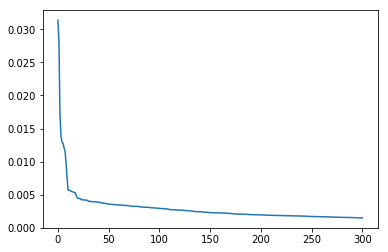

In [32]:
plt.plot(tr0_MI_ranked)

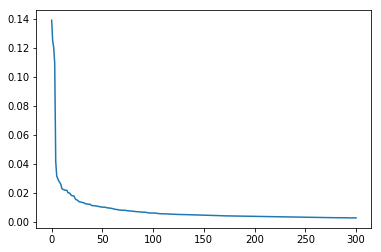

In [34]:
plt.plot(tr1_MI_ranked)

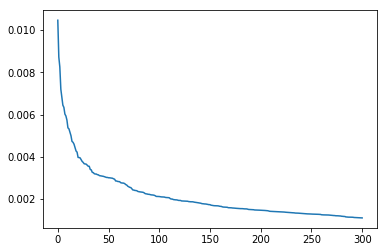

In [35]:
plt.plot(tr2_MI_ranked)

In [36]:
nf_0 = 10
tr0_MIidx, _ = argmax_MI(features_tr0, tr0['Bound'].as_matrix(), n_feats, bins)
tr0_MIfeats = np.take(features_tr0, tr0_MIidx, axis=1)

nf_1 = 16
tr1_MIidx, _ = argmax_MI(features_tr1, tr0['Bound'].as_matrix(), n_feats, bins)
tr1_MIfeats = np.take(features_tr1, tr1_MIidx, axis=1)

nf_2 = 50
tr2_MIidx, _ = argmax_MI(features_tr2, tr2['Bound'].as_matrix(), n_feats, bins)
tr2_MIfeats = np.take(features_tr2, tr2_MIidx, axis=1)